In [93]:
import pandas as pd
import glob
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from Bio import SeqIO
import tarfile
import gzip
%load_ext autoreload
%autoreload 2
from helpers_barplot_intersection import plot_intersection_bars, plotting_parameters, sort_filters, calculate_mean_std



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
def small_ratios(stats):
    stats['ohsu/eth'] = stats['size_ohsu']/stats['size_eth']

    div = []
    param = []
    prev_row = None
    prev_i = None
    for i, row in stats.iterrows():
        if prev_row is not None:
            div.append(row/prev_row)
            param.append(f'{str(i)}/{str(prev_i)}')
        prev_row = row
        prev_i = i 
    res = pd.DataFrame(div)
    res.index = param
    display(stats)
    display(res)

In [95]:
# INPUTS 

order_background = ['01', '12', '1X', '1A', '32', '3X', '3A']
order_foreground = ['025', '021', '0A5', '0A1', '0AN']

sample_plot_dir = {}
run_type_plot_dir = {}    
all_samples = []

# BRCA
samples = ['TCGA-C8-A12P-01A-11R-A115-07',
                  'TCGA-AO-A0JM-01A-21R-A056-07',
                  'TCGA-BH-A18V-01A-11R-A12D-07',
                  'TCGA-A2-A0D2-01A-21R-A034-07',
                  'TCGA-A2-A0SX-01A-12R-A084-07']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'BRCA'
    
# OV
samples = ['TCGA-25-1319-01A-01R-1565-13',
                  'TCGA-25-1313-01A-01R-1565-13',
                  'TCGA-61-2008-01A-02R-1568-13',
                  'TCGA-24-1431-01A-01R-1566-13',
                  'TCGA-24-2298-01A-01R-1569-13']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'OV'

save_folder = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots'

# PLOTTING Parameters 
ticks_fontsize = 12
axislabels_fontsize = 12
legend_fontsize = 12
axes_fontsize = 15
color1 = '#a3b49b'# #intersection
color2 = '#1d8ea9' #OHSU 
color3 = '#f27700' # #ETH
color4 = 'k' #text
colorgrid = 'grey'



save = False
sample = None

# Initialize plotting parameters
param_object = plotting_parameters(ticks_fontsize, axislabels_fontsize, legend_fontsize, axes_fontsize)
param_object.add_saving_instructions(save, run_type_plot_dir, sample_plot_dir)
param_object.add_color_options(color1, color2, color3, color4, colorgrid)



# Plot: Results per experiment

In [96]:
# Wrapper for plotting function 
def run_sample_plotting_overlap_filter(sample, df, param_object):

    # Ordering
    df_plot_ = sort_filters(df, order_background, order_foreground)
    df_plot = df_plot_.loc[df_plot_['sample'] == sample]

    
    # Plotting labels and ticks
    param_object.add_x_label('GTEX (reads, samples)', 
                             f'{param_object.run_type_plot_dir[sample].upper()} (min, reads, samples)')
    
    param_object.add_ticks(df_plot['filter_background'], df_plot['filter_foreground'] )
    
    
    param_object.add_plotting_data(data_eth=df_plot, 
                                   data_ohsu=df_plot, 
                                   data_both=df_plot, 
                                   serie_index='index', 
                                   serie_intersection='mean_size_intersection',
                                   serie_eth='mean_size_eth', 
                                   serie_ohsu='mean_size_ohsu')
    
    param_object.add_y_label('Number of filtered junction-9mers')
    
    name_file = f'barplot_intersect_filtering'
    if param_object.log_scale:
        name_file += '_log'
    param_object.add_saving_path(param_object.sample_plot_dir[sample], 
                                 f'MeanSample-{param_object.run_type_plot_dir[sample]}', name_file)
    
    param_object.add_labels('Mean intersection size', 'Mean total set size Graph Pipeline',
                            'Mean set size Junction Pipeline')
    
    param_object.add_title(f'')

    # Plotting function
    plot_intersection_bars(param_object)
    return df_plot, df_plot_

 Reading ['/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_filtering_ohsu_eth_ov.tsv.gz', '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_filtering_ohsu_eth_brca.tsv.gz']


,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu
0,TCGA-25-1313-01A-01R-1565-13,0AN1XGA,137232,31576,19025,118207,12551
1,TCGA-25-1319-01A-01R-1565-13,0A501GA,88503,41552,22489,66014,19063
2,TCGA-25-1313-01A-01R-1565-13,0AN1AGA,137232,31576,19025,118207,12551
3,TCGA-24-2298-01A-01R-1569-13,0A501GA,109227,54266,27949,81278,26317
4,TCGA-61-2008-01A-02R-1568-13,0AN3AGA,489800,102480,60116,429684,42364


Number of filtered junction-9mers
Stats Mean intersection size / min: 8049 / max: 44266 / mean: 24190.37 / median: 23985.0 / non_zero: 35/35
Stats Mean total set size Graph Pipeline / min: 18524 / max: 76226 / mean: 46216.34 / median: 47784.0 / non_zero: 35/35
Stats Mean set size Junction Pipeline / min: 21620 / max: 347795 / mean: 136014.34 / median: 81990.0 / non_zero: 35/35
Stats ratio JP/GP / min: 1.17 / max: 5.67 / mean: 2.63 / median: 2.06 / non_zero: 35/35
Stats stats inter/OHSU / min: 0.11 / max: 0.37 / mean: 0.24 / median: 0.26 / non_zero: 35/35
Stats stats inter/ETH / min: 0.41 / max: 0.6 / mean: 0.51 / median: 0.53 / non_zero: 35/35

 saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample-OV_barplot_intersect_filtering_log.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:263: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


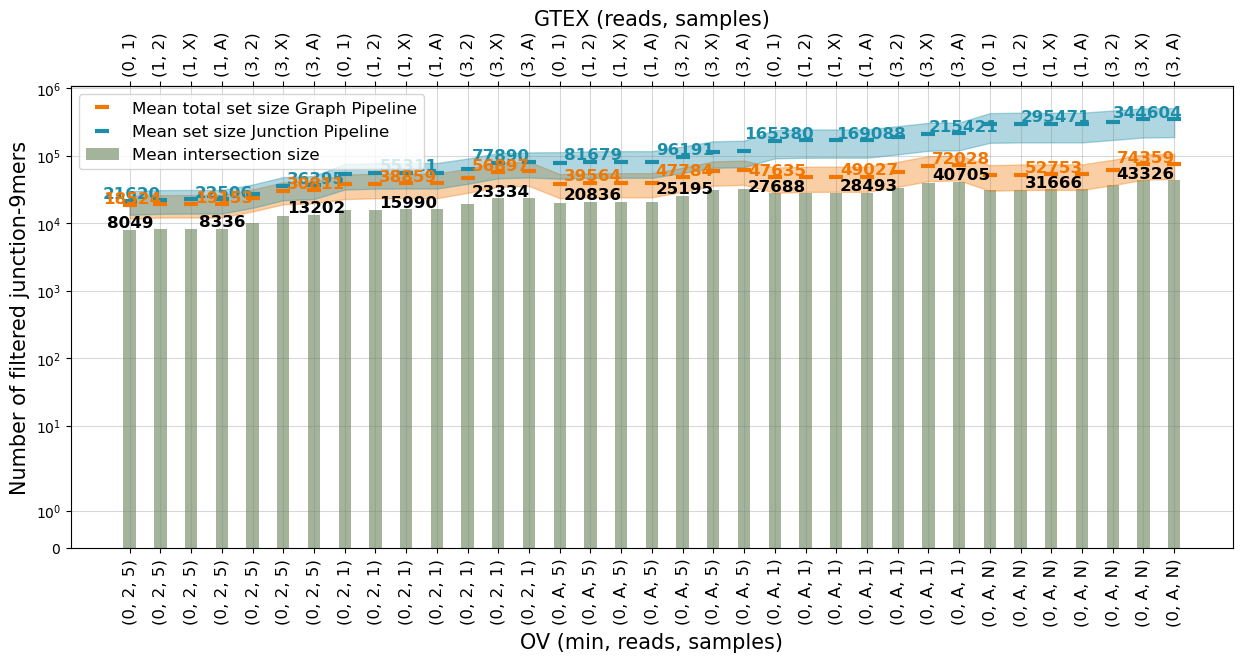

 Reading ['/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_filtering_ohsu_eth_ov.tsv.gz', '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_filtering_ohsu_eth_brca.tsv.gz']


,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu
0,TCGA-25-1313-01A-01R-1565-13,0AN1XGA,137232,31576,19025,118207,12551
1,TCGA-25-1319-01A-01R-1565-13,0A501GA,88503,41552,22489,66014,19063
2,TCGA-25-1313-01A-01R-1565-13,0AN1AGA,137232,31576,19025,118207,12551
3,TCGA-24-2298-01A-01R-1569-13,0A501GA,109227,54266,27949,81278,26317
4,TCGA-61-2008-01A-02R-1568-13,0AN3AGA,489800,102480,60116,429684,42364


Number of filtered junction-9mers
Stats Mean intersection size / min: 8049 / max: 44266 / mean: 24190.37 / median: 23985.0 / non_zero: 35/35
Stats Mean total set size Graph Pipeline / min: 18524 / max: 76226 / mean: 46216.34 / median: 47784.0 / non_zero: 35/35
Stats Mean set size Junction Pipeline / min: 21620 / max: 347795 / mean: 136014.34 / median: 81990.0 / non_zero: 35/35
Stats ratio JP/GP / min: 1.17 / max: 5.67 / mean: 2.63 / median: 2.06 / non_zero: 35/35
Stats stats inter/OHSU / min: 0.11 / max: 0.37 / mean: 0.24 / median: 0.26 / non_zero: 35/35
Stats stats inter/ETH / min: 0.41 / max: 0.6 / mean: 0.51 / median: 0.53 / non_zero: 35/35

 saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample-OV_barplot_intersect_filtering.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:263: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


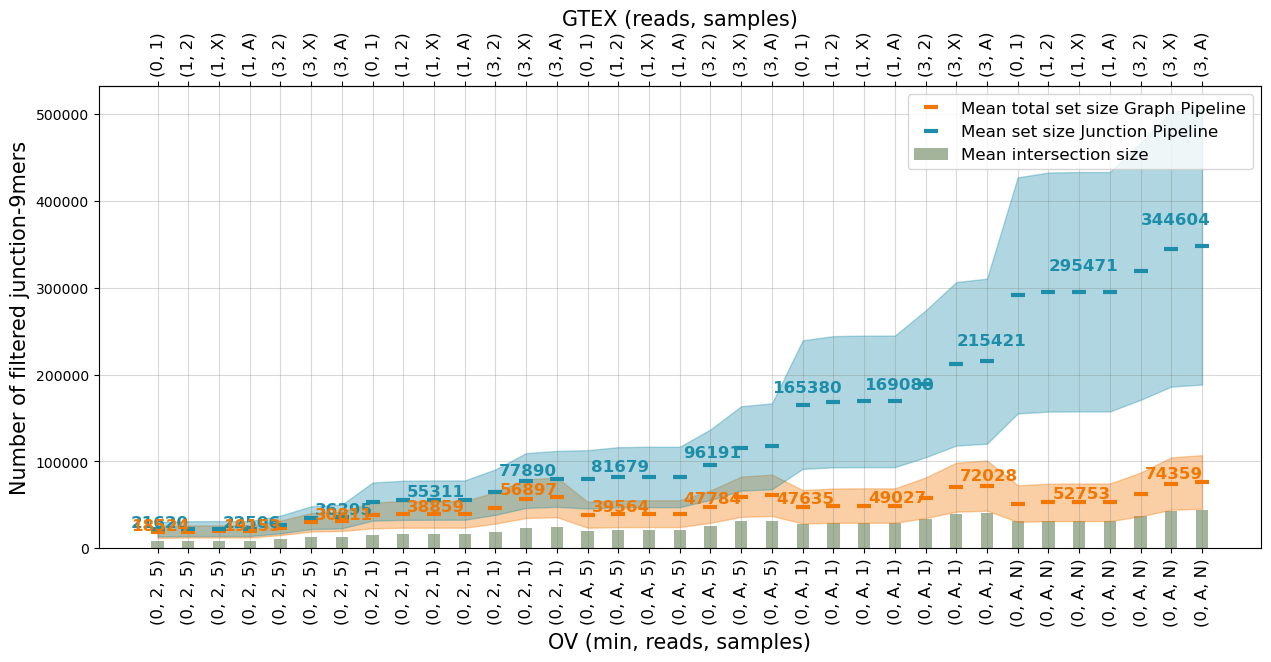

 Reading ['/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_filtering_ohsu_eth_ov.tsv.gz', '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_filtering_ohsu_eth_brca.tsv.gz']


,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu
0,TCGA-25-1313-01A-01R-1565-13,0AN1XGA,137232,31576,19025,118207,12551
1,TCGA-25-1319-01A-01R-1565-13,0A501GA,88503,41552,22489,66014,19063
2,TCGA-25-1313-01A-01R-1565-13,0AN1AGA,137232,31576,19025,118207,12551
3,TCGA-24-2298-01A-01R-1569-13,0A501GA,109227,54266,27949,81278,26317
4,TCGA-61-2008-01A-02R-1568-13,0AN3AGA,489800,102480,60116,429684,42364


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:263: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


Number of filtered junction-9mers
Stats Mean intersection size / min: 4 / max: 520 / mean: 101.51 / median: 47.0 / non_zero: 35/35
Stats Mean total set size Graph Pipeline / min: 10 / max: 678 / mean: 149.37 / median: 65.0 / non_zero: 35/35
Stats Mean set size Junction Pipeline / min: 19 / max: 7734 / mean: 1364.51 / median: 340.0 / non_zero: 35/35
Stats ratio JP/GP / min: 1.28 / max: 22.82 / mean: 6.37 / median: 3.7 / non_zero: 35/35
Stats stats inter/OHSU / min: 0.03 / max: 0.42 / mean: 0.18 / median: 0.17 / non_zero: 35/35
Stats stats inter/ETH / min: 0.4 / max: 0.77 / mean: 0.61 / median: 0.62 / non_zero: 35/35

 saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample-BRCA_barplot_intersect_filtering_log.pdf


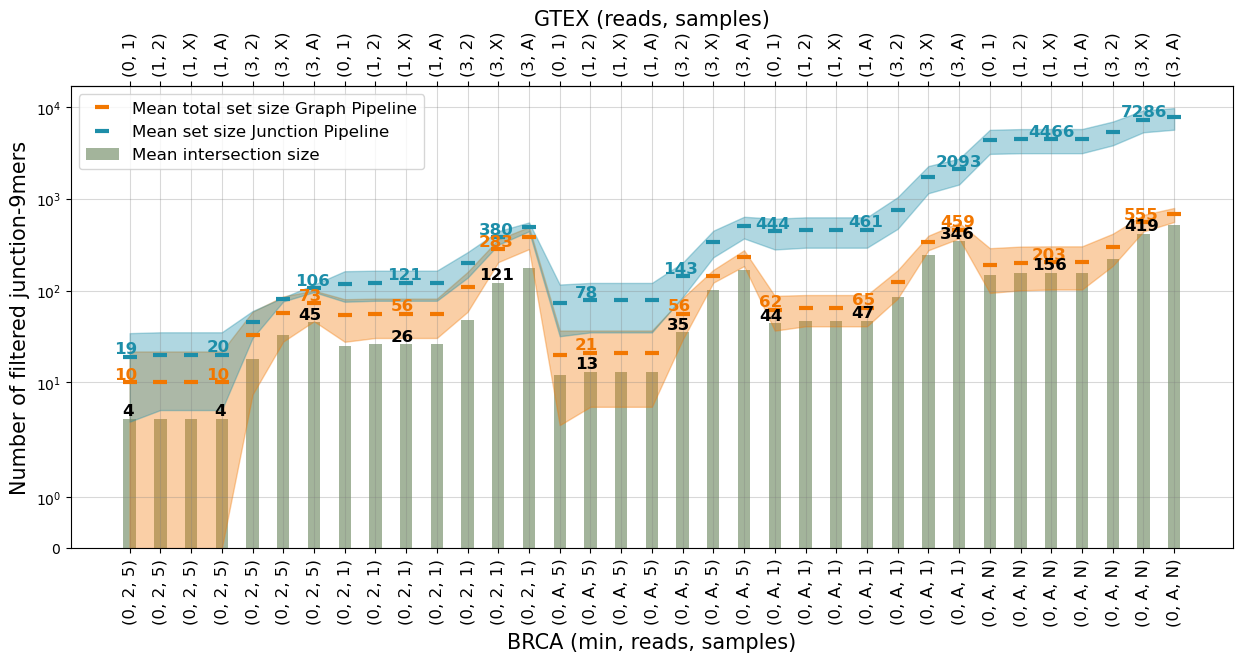

 Reading ['/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_filtering_ohsu_eth_ov.tsv.gz', '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_filtering_ohsu_eth_brca.tsv.gz']


,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu
0,TCGA-25-1313-01A-01R-1565-13,0AN1XGA,137232,31576,19025,118207,12551
1,TCGA-25-1319-01A-01R-1565-13,0A501GA,88503,41552,22489,66014,19063
2,TCGA-25-1313-01A-01R-1565-13,0AN1AGA,137232,31576,19025,118207,12551
3,TCGA-24-2298-01A-01R-1569-13,0A501GA,109227,54266,27949,81278,26317
4,TCGA-61-2008-01A-02R-1568-13,0AN3AGA,489800,102480,60116,429684,42364


Number of filtered junction-9mers
Stats Mean intersection size / min: 4 / max: 520 / mean: 101.51 / median: 47.0 / non_zero: 35/35
Stats Mean total set size Graph Pipeline / min: 10 / max: 678 / mean: 149.37 / median: 65.0 / non_zero: 35/35
Stats Mean set size Junction Pipeline / min: 19 / max: 7734 / mean: 1364.51 / median: 340.0 / non_zero: 35/35
Stats ratio JP/GP / min: 1.28 / max: 22.82 / mean: 6.37 / median: 3.7 / non_zero: 35/35
Stats stats inter/OHSU / min: 0.03 / max: 0.42 / mean: 0.18 / median: 0.17 / non_zero: 35/35
Stats stats inter/ETH / min: 0.4 / max: 0.77 / mean: 0.61 / median: 0.62 / non_zero: 35/35

 saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/MeanSample-BRCA_barplot_intersect_filtering.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:263: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


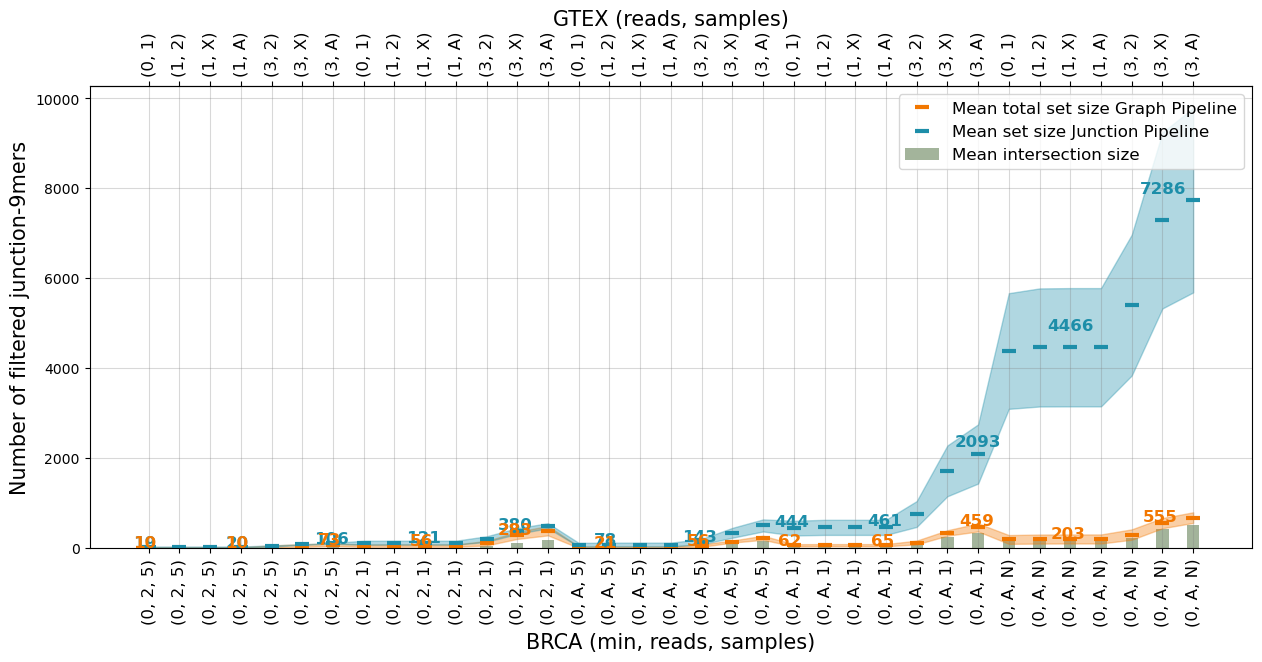

In [105]:
# MAIN 

both_cohorts = []
for sample in ['TCGA-25-1319-01A-01R-1565-13', 'TCGA-AO-A0JM-01A-21R-A056-07']:
    for log_option in [True, False]:
        # Intermediate paths filtering
        order_file = os.path.join(sample_plot_dir[sample], f'{sample}_Barplot_sorting.tsv.gz')

        # Intermediate data path MS results
        path_data_pep = glob.glob(os.path.join(save_folder, f'data_kmers_filtering_ohsu_eth*.tsv.gz'))

        # Read data and plot
        group_cols = ['filter_']
        target_cols = ['size_ohsu', 'size_eth', 'size_intersection', 
                          'size_ohsu\eth', 'size_eth\ohsu']
        print(f' Reading {path_data_pep}')
        df = pd.concat([pd.read_csv(path_data, sep = '\t') for path_data in path_data_pep])
        display(df.head())
        df = calculate_mean_std(df, group_cols, target_cols, run_type_plot_dir, sample, decimals=0)
        param_object.edit_marker(marker_type = "_", marker_size = 10, markeredgewidth=3)
        param_object.edit_scale(is_log_scale=log_option)
        df_plot, df_plot_ = run_sample_plotting_overlap_filter(sample, df, param_object)
        if not log_option:
            both_cohorts.append(df_plot_)

In [98]:
df_plot_['sample'].unique()

array(['TCGA-C8-A12P-01A-11R-A115-07', 'TCGA-AO-A0JM-01A-21R-A056-07',
       'TCGA-BH-A18V-01A-11R-A12D-07', 'TCGA-A2-A0D2-01A-21R-A034-07',
       'TCGA-A2-A0SX-01A-12R-A084-07'], dtype=object)

In [104]:
len(both_cohorts)

4

----------------------------------------------------
filter_background_reads
['TCGA-25-1319-01A-01R-1565-13' 'TCGA-25-1313-01A-01R-1565-13'
 'TCGA-61-2008-01A-02R-1568-13' 'TCGA-24-1431-01A-01R-1566-13'
 'TCGA-24-2298-01A-01R-1569-13']


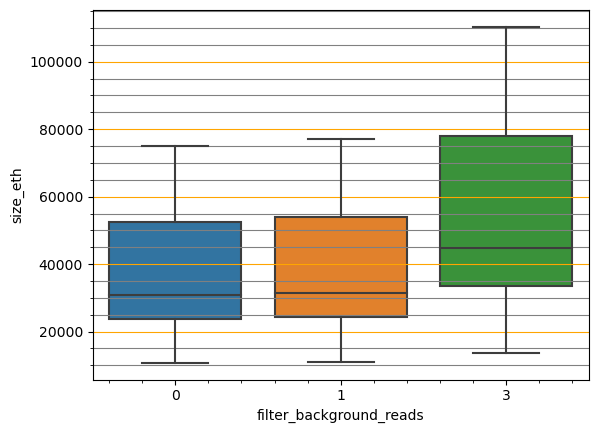

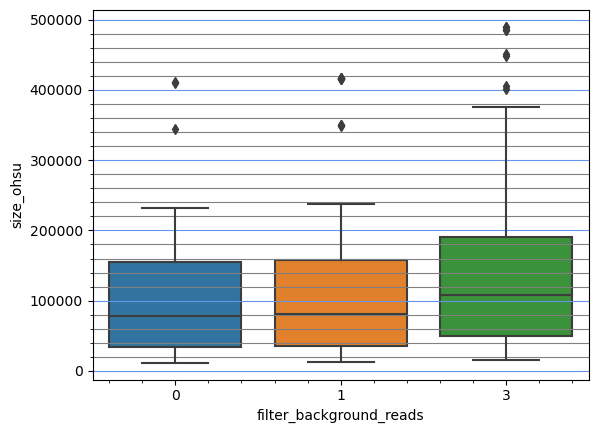

mean


,size_ohsu,size_eth,ohsu/eth
filter_background_reads,,,
0,122217.080000,38722.000000,3.156270
1,124779.200000,39860.253333,3.130417
3,151848.546667,55070.560000,2.757345


,size_ohsu,size_eth,ohsu/eth
1/0,1.020964,1.029396,0.991809
3/1,1.216938,1.381591,0.880824


median


,size_ohsu,size_eth,ohsu/eth
filter_background_reads,,,
0,78797,30812,2.557348
1,80480,31576,2.548771
3,107892,44816,2.407444


,size_ohsu,size_eth,ohsu/eth
1/0,1.021359,1.024796,0.996646
3/1,1.340606,1.419306,0.944551


max


,size_ohsu,size_eth,ohsu/eth
filter_background_reads,,,
0,411595,74984,5.489104
1,417374,76970,5.422554
3,489800,110350,4.438604


,size_ohsu,size_eth,ohsu/eth
1/0,1.014041,1.026486,0.987876
3/1,1.173528,1.433675,0.818545


75 quantile


,size_ohsu,size_eth,ohsu/eth
filter_background_reads,,,
0,155507.0,52430.0,2.965993
1,157872.0,53930.0,2.927350
3,190024.5,78012.5,2.435821


,size_ohsu,size_eth,ohsu/eth
1/0,1.015208,1.028610,0.986971
3/1,1.203662,1.446551,0.832091


filter_background_samples
['TCGA-25-1319-01A-01R-1565-13' 'TCGA-25-1313-01A-01R-1565-13'
 'TCGA-61-2008-01A-02R-1568-13' 'TCGA-24-1431-01A-01R-1566-13'
 'TCGA-24-2298-01A-01R-1569-13']


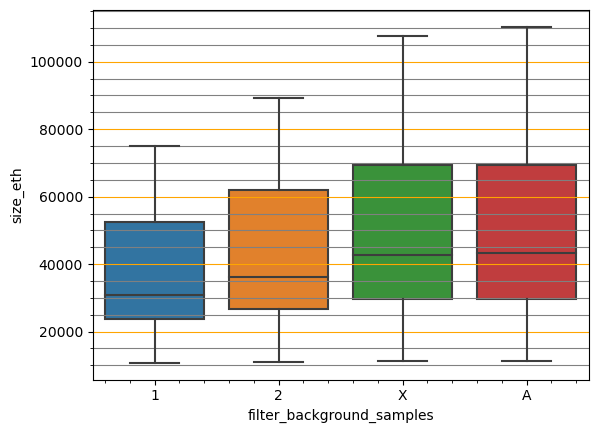

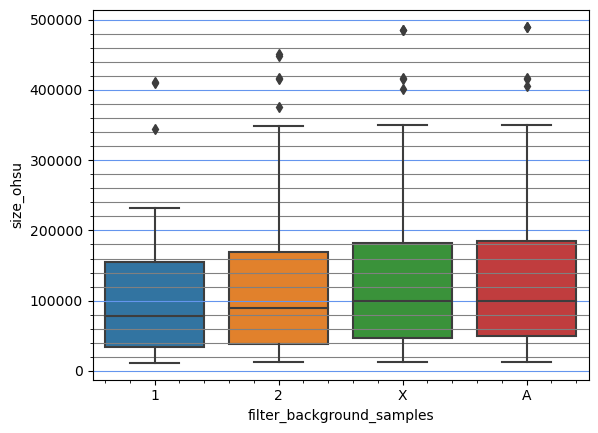

mean


,size_ohsu,size_eth,ohsu/eth
filter_background_samples,,,
1,122217.08,38722.00,3.156270
2,131912.36,43617.66,3.024288
A,142106.92,49795.24,2.853825
X,140922.34,48983.32,2.876945


,size_ohsu,size_eth,ohsu/eth
2/1,1.079328,1.126431,0.958184
A/2,1.077283,1.141630,0.943635
X/A,0.991664,0.983695,1.008101


median


,size_ohsu,size_eth,ohsu/eth
filter_background_samples,,,
1,78797.0,30812.0,2.557348
2,89639.5,36276.5,2.471007
A,100133.5,43353.5,2.309698
X,99197.5,42750.0,2.320409


,size_ohsu,size_eth,ohsu/eth
2/1,1.137600,1.177350,0.966238
A/2,1.117069,1.195085,0.934719
X/A,0.990652,0.986080,1.004637


max


,size_ohsu,size_eth,ohsu/eth
filter_background_samples,,,
1,411595,74984,5.489104
2,450571,89331,5.043837
A,489800,110350,4.438604
X,485569,107712,4.508031


,size_ohsu,size_eth,ohsu/eth
2/1,1.094695,1.191334,0.918882
A/2,1.087065,1.235293,0.880006
X/A,0.991362,0.976094,1.015641


75 quantile


,size_ohsu,size_eth,ohsu/eth
filter_background_samples,,,
1,155507.00,52430.0,2.965993
2,168601.00,61835.5,2.726605
A,184625.25,69248.5,2.666126
X,182149.00,69248.5,2.630367


,size_ohsu,size_eth,ohsu/eth
2/1,1.084202,1.179392,0.919289
A/2,1.095042,1.119883,0.977819
X/A,0.986588,1.000000,0.986588


----------------------------------------------------
filter_background_reads
['TCGA-C8-A12P-01A-11R-A115-07' 'TCGA-AO-A0JM-01A-21R-A056-07'
 'TCGA-BH-A18V-01A-11R-A12D-07' 'TCGA-A2-A0D2-01A-21R-A034-07'
 'TCGA-A2-A0SX-01A-12R-A084-07']


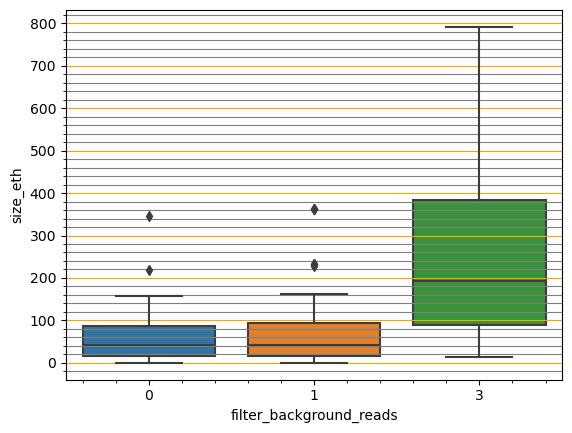

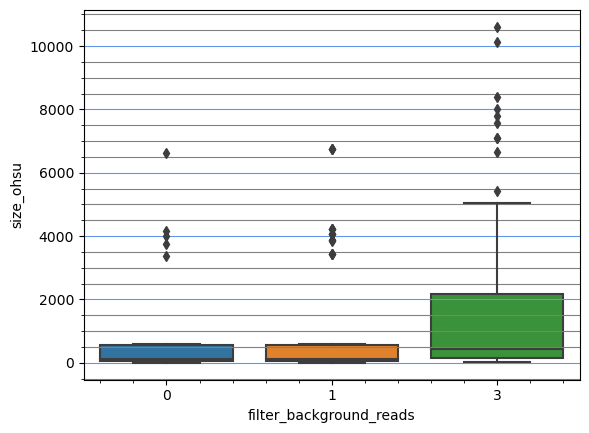

mean


,size_ohsu,size_eth,ohsu/eth
filter_background_reads,,,
0,1007.520000,67.600000,14.904142
1,1028.893333,70.773333,14.537867
3,1819.106667,255.053333,7.132260


,size_ohsu,size_eth,ohsu/eth
1/0,1.021214,1.046943,0.975425
3/1,1.768023,3.603806,0.490599


median


,size_ohsu,size_eth,ohsu/eth
filter_background_reads,,,
0,120,42,2.857143
1,120,42,2.857143
3,445,193,2.305699


,size_ohsu,size_eth,ohsu/eth
1/0,1.000000,1.000000,1.000000
3/1,3.708333,4.595238,0.806995


max


,size_ohsu,size_eth,ohsu/eth
filter_background_reads,,,
0,6618,346,19.127168
1,6756,362,18.662983
3,10611,792,13.397727


,size_ohsu,size_eth,ohsu/eth
1/0,1.020852,1.046243,0.975732
3/1,1.570604,2.187845,0.717877


75 quantile


,size_ohsu,size_eth,ohsu/eth
filter_background_reads,,,
0,552.0,87.0,6.344828
1,570.0,94.0,6.063830
3,2186.0,384.0,5.692708


,size_ohsu,size_eth,ohsu/eth
1/0,1.032609,1.080460,0.955712
3/1,3.835088,4.085106,0.938798


filter_background_samples
['TCGA-C8-A12P-01A-11R-A115-07' 'TCGA-AO-A0JM-01A-21R-A056-07'
 'TCGA-BH-A18V-01A-11R-A12D-07' 'TCGA-A2-A0D2-01A-21R-A034-07'
 'TCGA-A2-A0SX-01A-12R-A084-07']


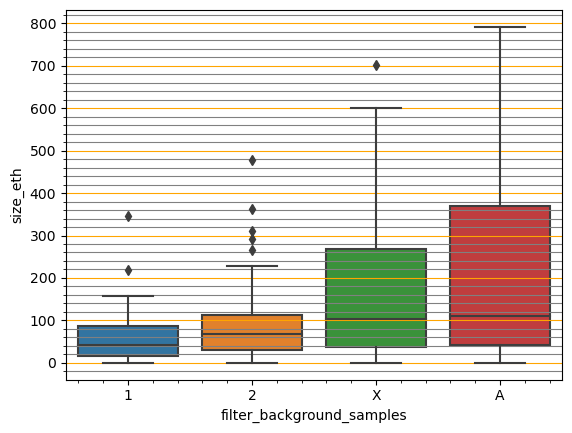

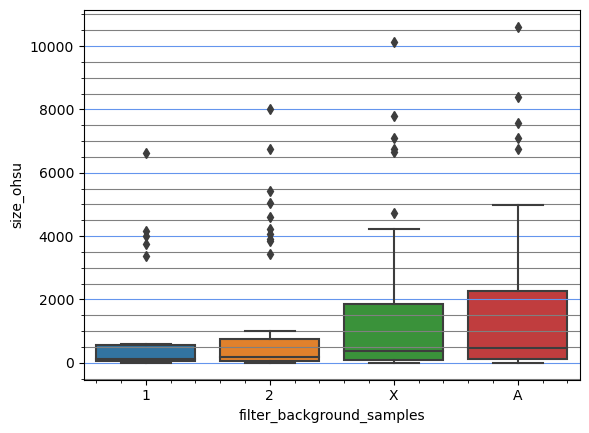

mean


,size_ohsu,size_eth,ohsu/eth
filter_background_samples,,,
1,1007.52,67.60,14.904142
2,1169.00,97.50,11.989744
A,1608.16,218.24,7.368768
X,1494.84,173.00,8.640694


,size_ohsu,size_eth,ohsu/eth
2/1,1.160275,1.442308,0.804457
A/2,1.375672,2.238359,0.614589
X/A,0.929534,0.792705,1.172610


median


,size_ohsu,size_eth,ohsu/eth
filter_background_samples,,,
1,120.0,42.0,2.857143
2,172.5,67.5,2.555556
A,477.5,110.0,4.340909
X,378.5,103.0,3.674757


,size_ohsu,size_eth,ohsu/eth
2/1,1.437500,1.607143,0.894444
A/2,2.768116,1.629630,1.698617
X/A,0.792670,0.936364,0.846541


max


,size_ohsu,size_eth,ohsu/eth
filter_background_samples,,,
1,6618,346,19.127168
2,8019,479,16.741127
A,10611,792,13.397727
X,10146,703,14.432432


,size_ohsu,size_eth,ohsu/eth
2/1,1.211695,1.384393,0.875254
A/2,1.323232,1.653445,0.800288
X/A,0.956178,0.887626,1.077230


75 quantile


,size_ohsu,size_eth,ohsu/eth
filter_background_samples,,,
1,552.00,87.00,6.344828
2,762.00,112.50,6.773333
A,2257.75,370.25,6.097907
X,1852.50,268.75,6.893023


,size_ohsu,size_eth,ohsu/eth
2/1,1.380435,1.293103,1.067536
A/2,2.962927,3.291111,0.900282
X/A,0.820507,0.725861,1.130392


In [112]:
for df_plot_ in both_cohorts:
    print('----------------------------------------------------')
    for x in [
#            'filter_foreground_reads',
#            'filter_foreground_samples']:
           'filter_background_reads',
           'filter_background_samples']:
        print(x)
        print(df_plot_['sample'].unique())
        plt.minorticks_on() 
        plt.grid(True, which='minor', axis='y', color='grey', linestyle='-')
        plt.grid(True, which='major', color='orange', linestyle='-')
        sns.boxplot(data =df_plot_, y='size_eth', x=x)
        plt.show()
        plt.minorticks_on() 
        plt.grid(True, which='minor', axis='y', color='grey', linestyle='-')
        plt.grid(True, which='major', color='cornflowerblue', linestyle='-')
        sns.boxplot(data =df_plot_, y='size_ohsu', x=x)
        plt.show()


        print('mean')
        stats = df_plot_.groupby(x).mean()[['size_ohsu', 'size_eth']]
        small_ratios(stats)
        print('median')
        stats = df_plot_.groupby(x).median()[['size_ohsu', 'size_eth']]
        small_ratios(stats)
        print('max')
        stats = df_plot_.groupby(x).max()[['size_ohsu', 'size_eth']]
        small_ratios(stats)
        print('75 quantile')
        stats = df_plot_.groupby(x).quantile(0.75)[['size_ohsu', 'size_eth']]
        small_ratios(stats)